# DNN for segmenting Poker Cards

1. Build dataset using classical method. [Level Set](https://profs.etsmtl.ca/hlombaert/levelset/) **DONE** See AutoSegmentation Notebook
2. Sythesize more data by copying and pasting. [Paper](https://arxiv.org/pdf/1708.01642.pdf)
3. Use contrastive learning to turn [Semantic Segmentation Model](https://pytorch.org/vision/stable/models.html#semantic-segmentation) into Instance Segmentation and possibly classification. [Paper](https://arxiv.org/pdf/1708.02551.pdf)

# Sythetic Dataset

- Generate on-the-fly
- Maintain Img, Mask for each intance type

In [1]:
import cv2 as cv
import json
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
!wget -nc https://storage.googleapis.com/pipat-public-temp-storage/bicyclecard.zip
!unzip bicyclecard.zip

--2023-05-21 13:49:40--  https://storage.googleapis.com/pipat-public-temp-storage/bicyclecard.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2921288 (2.8M) [application/zip]
Saving to: ‘bicyclecard.zip’

bicyclecard.zip     100%[===================>]   2.79M  1.63MB/s    in 1.7s    

2023-05-21 13:49:44 (1.63 MB/s) - ‘bicyclecard.zip’ saved [2921288/2921288]

Archive:  bicyclecard.zip
   creating: bicyclecard/
   creating: bicyclecard/images/
  inflating: bicyclecard/images/IMG_20230520_181747585.jpg  
  inflating: bicyclecard/images/IMG_20230520_185539556.jpg  
  inflating: bicyclecard/images/IMG_20230520_190114760.jpg  
  inflating: bicyclecard/images/IMG_20230520_181300821.jpg  
  inflating: bicyclecard/images/IMG_20230520_190510297.jpg  
  inflating: bicyclecard/i

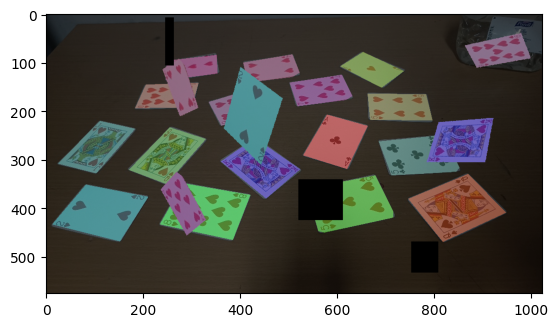

In [4]:
class TrainingGenerator:
    
    COCO_ANNOT_PATH = "./bicyclecard/bicyclecard.json"
    COCO_DATA_PATH = "./bicyclecard/images/"
    
    def __init__(self):
        with open(self.COCO_ANNOT_PATH, "r") as f:
            self.coco = json.load(f)
        
        self.images = {m['id']:m for m in self.coco["images"]}
        self.segmentations = {k:[] for k in self.images.keys()}
        for ann in self.coco['annotations']:
            self.segmentations[ann['image_id']].append(np.array(ann['segmentation'][0], dtype='int32').reshape(-1, 2))
            
    def load_base_img(self, holdout=False):
        if not holdout:
            img_ann = random.choice(list(self.images.values())[:-1])
        else:
            img_ann = list(self.images.values())[-1]
        self.cimg = cv.cvtColor(cv.imread(self.COCO_DATA_PATH + img_ann['file_name']), cv.COLOR_BGR2RGB)
        self.cmasks = []
        self.cmasks_bbox = []
        self.bimg = self.cimg.copy()
        self.bmasks = []
        for ann in self.segmentations[img_ann['id']]:
            mask = np.zeros((self.cimg.shape[0], self.cimg.shape[1]), dtype="uint8")
            cv.fillPoly(mask, [ann], [1])
            self.bmasks.append(mask)
            self.cmasks.append(mask.copy())
            self.cmasks_bbox.append([self.bbox(mask)])
            
    def blend(self, img, mask, tid):
        self.cimg *= np.expand_dims(mask==0, 2)
        self.cimg += img * np.expand_dims(mask==1, 2)
        for i, m in enumerate(self.cmasks):
            if i == tid:
                m |= mask
                self.cmasks_bbox[i].append(self.bbox(mask))
                xmin, xmax, ymin, ymax = self.bbox(mask)
            else:
                m &= ~mask
        
    def bbox(self, mask):
        mask_loc = np.argwhere(mask)
        xmin, xmax, ymin, ymax = mask_loc[:, 1].min(), mask_loc[:, 1].max(), mask_loc[:, 0].min(), mask_loc[:, 0].max()
        return xmin, xmax, ymin, ymax
            
    def copy_paste(self):
        tid = np.random.randint(len(self.bmasks))
        mask = self.bmasks[tid]
        
        xmin, xmax, ymin, ymax = self.bbox(mask)
        image_center = ((xmin+xmax)/2, (ymin+ymax)/2)
        mat = cv.getRotationMatrix2D(image_center, np.random.randint(180), 1)
        mat[:, 2] -= image_center
        mat[:, 2] += np.random.rand(2) * mask.shape[:2][::-1]
        
        maskp = cv.warpAffine(mask, mat, (mask.shape[1], mask.shape[0]))
        imgp = cv.warpAffine(self.bimg, mat, (mask.shape[1], mask.shape[0]))
        
        self.blend(imgp, maskp, tid)
        
    def corrupt(self):
        x, y, w, h = map(int, np.random.rand(4) * [self.cimg.shape[1], self.cimg.shape[0], 100, 100])
        m = np.zeros([self.cimg.shape[0], self.cimg.shape[1]], dtype='bool')
        m[y:y+h, x:x+w] = 1
        self.blend(np.zeros_like(self.cimg), m, -1)
    
    def visualize_state(self):
        plt.figure()
        plt.imshow(self.cimg)
        all_masks = np.zeros_like(self.bimg)
        for m in self.cmasks:
            color = np.random.rand(3)
            color /= color.sum()
            color *= 255
            all_masks += np.expand_dims(m, 2) @ color.astype('uint8').reshape(1, 3)
        plt.imshow(all_masks, alpha=0.6)
        
    def output(self):
        all_mask = np.zeros_like(self.cmasks[0])
        for m in self.cmasks:
            all_mask |= m
        return self.cimg, self.cmasks, m, self.cmasks_bbox

gen = TrainingGenerator()
gen.load_base_img()
for _ in range(5):
    gen.copy_paste()
for _ in range(3):    
    gen.corrupt()
gen.visualize_state()

# Model

In [5]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm

In [65]:
gen = TrainingGenerator()
def gen_img(holdout=False):
    gen.load_base_img(holdout=holdout)
    if not holdout:
      for _ in range(5):
          gen.copy_paste()
      
      for _ in range(3):    
          gen.corrupt()
  
    return gen.output()

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [102]:
fg_loss = nn.BCEWithLogitsLoss()

CLUS_DIST = 1
INTER_DIST = 2

CENTER_REG = 0.001


def cal_loss(output, target):
    # torch.Size([1, 32, 520, 924])
    # target = masks, all_masks # [576, 1024]
    rsz = lambda x: F.interpolate(torch.Tensor(x).unsqueeze(0).unsqueeze(0), output.shape[-2:]).squeeze().to(device) # [520 924]
    masks, all_mask, bboxs = target
    all_mask = rsz(all_mask)
    masks = [rsz(mask) for mask  in masks]
    
    assert output.shape == (1, 32, 520, 924)
    features = output.squeeze().permute((1, 2, 0)) # [520 924 32]
    
    # FG Loss
    loss = torch.scalar_tensor(0).to(device)
    loss += fg_loss(features.reshape(-1, 32)[:, 0], all_mask.reshape(-1))
    assert not torch.isnan(loss)

    
    #  Intra-Cluster
    total_cluster_var = torch.scalar_tensor(0).to(device)

    
    cluster_means = []
    
    for m, bs in zip(masks, bboxs):
        cluster_mean = torch.zeros([1, 31]).to(device)
        pixcnt = torch.scalar_tensor(0).to(device)
        cluster_var = torch.scalar_tensor(0).to(device)
        for b in bs:
            xmin, xmax, ymin, ymax = b
            cluster_mean += (features[ymin:ymax, xmin:xmax, 1:] * m[ymin:ymax, xmin:xmax].unsqueeze(2)).reshape(-1, 31).sum(dim=0, keepdim=True)
            pixcnt += m[ymin:ymax, xmin:xmax].sum()
            
        if pixcnt.item() == 0:
            # Zero Segments
            continue

        assert not torch.any(torch.isnan(cluster_mean))
            
        cluster_mean /= pixcnt
        cluster_means.append(cluster_mean)
        
        for b in bs:
            xmin, xmax, ymin, ymax = b
            center_dist = ((features[ymin:ymax, xmin:xmax, 1:].reshape(-1, 31) - cluster_mean).pow(2).sum(dim=1).sqrt() * m[ymin:ymax, xmin:xmax].reshape(-1))
            cluster_var += torch.maximum(torch.Tensor([0]).to(device), center_dist - CLUS_DIST).pow(2).sum()

        assert not torch.isnan(cluster_var)
        
        cluster_var /= pixcnt
        
        total_cluster_var += cluster_var

        
    loss += total_cluster_var/len(masks)

    assert not torch.isnan(loss)
   
    
    inter_cluster = torch.scalar_tensor(0).to(device)
    n_inter_cluster = 0
    
    for i in range(len(cluster_means)):
        for j in range(i + 1, len(cluster_means)):
            n_inter_cluster += 1
            inter_cluster += torch.max(torch.scalar_tensor(0).to(device), INTER_DIST - (cluster_means[i] - cluster_means[j]).pow(2).sum().sqrt()).pow(2)

    assert n_inter_cluster != 0
    loss += inter_cluster/n_inter_cluster
    assert not torch.isnan(loss)

    loss += CENTER_REG * torch.mean(torch.stack([c.pow(2).sum().sqrt() for c in cluster_means]))
    assert not torch.isnan(loss)
    
    return loss

In [175]:
model = lraspp_mobilenet_v3_large(
    num_classes=32,
).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
transform = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
loss_hist = []
val_loss_hist = []

In [181]:
for epoch in tqdm(range(100)):
    acc_loss = []
    model.train()
    BATCH_SIZE = 30

    for i in tqdm(range(BATCH_SIZE)):
        try:
            optim.zero_grad()
            img, masks, all_mask, bbox = gen_img()
            img = torch.Tensor(img.transpose([2, 0, 1]))/255
            out = model(transform(img).unsqueeze(0).to(device))['out']
            loss = cal_loss(out, (masks, all_mask, bbox))
            loss.backward()
            optim.step()
            acc_loss.append(loss.item())
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        except Exception as e:
            gen.visualize_state()
            raise e
    print("Loss:", np.mean(acc_loss))
    loss_hist.append(np.mean(acc_loss))
    model.eval()
    with torch.no_grad():
        img, masks, all_mask, bbox = gen_img(holdout=True)
        img = torch.Tensor(img.transpose([2, 0, 1]))/255
        out = model(transform(img).unsqueeze(0).to(device))['out']
        loss = cal_loss(out, (masks, all_mask, bbox))
        print("Val Loss:", loss.item())
        val_loss_hist.append(loss.item())
        if len(val_loss_hist) == 1 or val_loss_hist[-1] < val_loss_hist[-2]:
          torch.save(model.state_dict(), "bestk.pth")
        torch.save(model.state_dict(), f"epochA-{epoch}.pth")
        torch.save(model.state_dict(), f"last.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.10746129776040712
Val Loss: 0.30785250663757324


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.09812919447819392
Val Loss: 0.2881116569042206


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.08575442185004552
Val Loss: 0.26060211658477783


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.07988075837492943
Val Loss: 0.2577246427536011


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.07793858498334885
Val Loss: 0.24801957607269287


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.0736022183050712
Val Loss: 0.2482631951570511


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.06739502288401127
Val Loss: 0.2576449513435364


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.05981313809752464
Val Loss: 0.24708910286426544


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.053356426085035005
Val Loss: 0.23094286024570465


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.05140799954533577
Val Loss: 0.21938200294971466


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.05599483102560043
Val Loss: 0.26905956864356995


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.04824169911444187
Val Loss: 0.2497267872095108


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.05024602959553401
Val Loss: 0.23242540657520294


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.048687497278054555
Val Loss: 0.2192034125328064


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.05073104842255513
Val Loss: 0.22724725306034088


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.04559779235472282
Val Loss: 0.23522771894931793


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.0383304251357913
Val Loss: 0.24103327095508575


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.0395450424713393
Val Loss: 0.23752494156360626


  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.03546854654947917
Val Loss: 0.25385621190071106


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [180]:
# Unstuck Adam https://datascience.stackexchange.com/questions/25024/strange-behavior-with-adam-optimizer-when-training-for-too-long
model.load_state_dict(torch.load('last.pth'))
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [149]:
!cp epoch-8.pth epoch-8.pth.bak

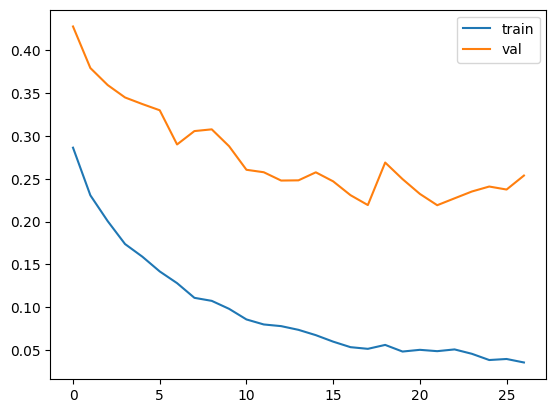

In [183]:
plt.plot(loss_hist, label="train")
plt.plot(val_loss_hist, label="val")
plt.legend()

# Inference

In [76]:
import cv2 as cv
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm

In [78]:
WEIGHT_PATH = "./card-embedding-model.pth" # Loss=0.24

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = lraspp_mobilenet_v3_large(
    num_classes=32,
).to(device)
transform = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
model.eval()
model.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))

<All keys matched successfully>

/home/pipat/ScratchPad/CompVision/Card-detection/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


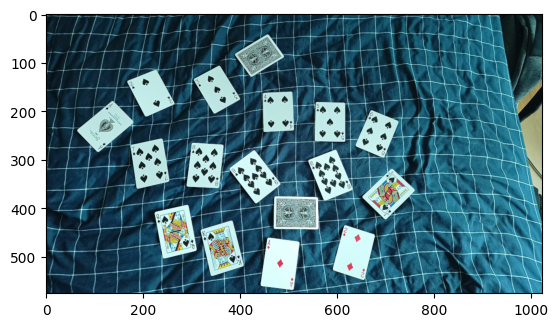

In [79]:
#IMG_PATH = "../assets/sample/testsmp1.jpg"
IMG_PATH = "../assets/sample/cardset1.jpg"

img = cv.cvtColor(cv.imread(IMG_PATH), cv.COLOR_BGR2RGB)
plt.imshow(img)
img = torch.Tensor(img.transpose([2, 0, 1]))/255
with torch.no_grad():
    out = model(transform(img).unsqueeze(0).to(device))['out']
    out = out.cpu().numpy()

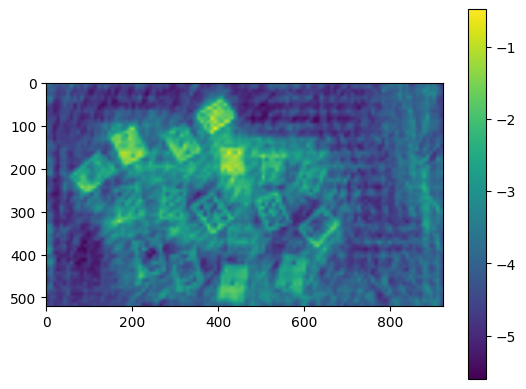

In [80]:
plt.imshow(out[0, 0, :, :])
plt.colorbar()

In [81]:
from sklearn.cluster import KMeans
m = KMeans(n_clusters=10)
instance_model = m.fit_predict(out[0, 1:, :, :].transpose([1, 2, 0]).reshape(-1, 31))

/home/pipat/ScratchPad/CompVision/Card-detection/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


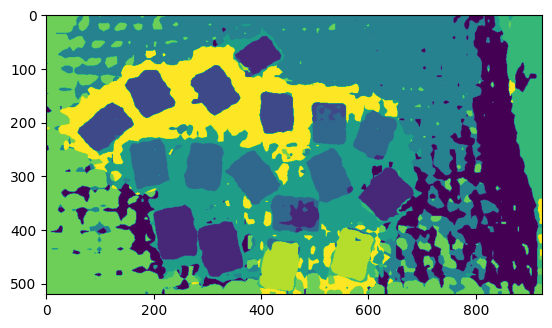

In [82]:
plt.imshow(instance_model.reshape(520, 924))

/home/pipat/ScratchPad/CompVision/Card-detection/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


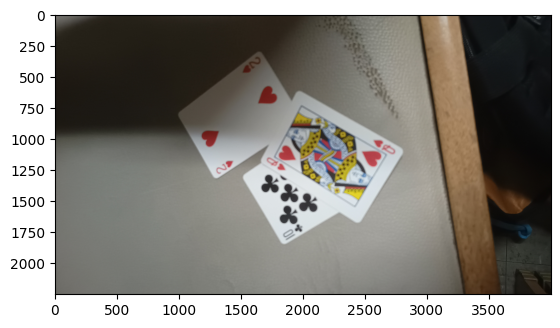

In [83]:
IMG2_PATH = "../assets/sample/testsmp2.jpg"
# IMG_PATH = "../assets/sample/cardset1.jpg"

img2 = cv.cvtColor(cv.imread(IMG2_PATH), cv.COLOR_BGR2RGB)
plt.imshow(img2)
img2 = torch.Tensor(img2.transpose([2, 0, 1]))/255
with torch.no_grad():
    out = model(transform(img2).unsqueeze(0).to(device))['out']
    out = out.cpu().numpy()
instance_pred = m.predict(out[0, 1:, :, :].transpose([1, 2, 0]).reshape(-1, 31))

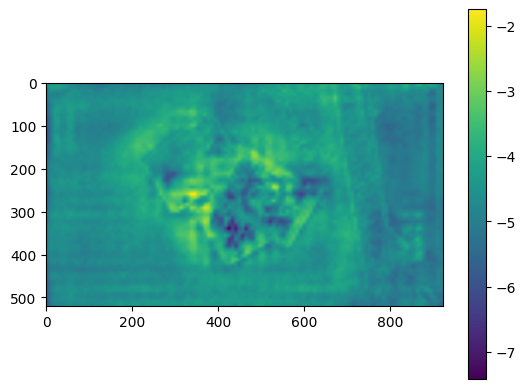

In [84]:
plt.imshow(out[0, 0, :, :])
plt.colorbar()

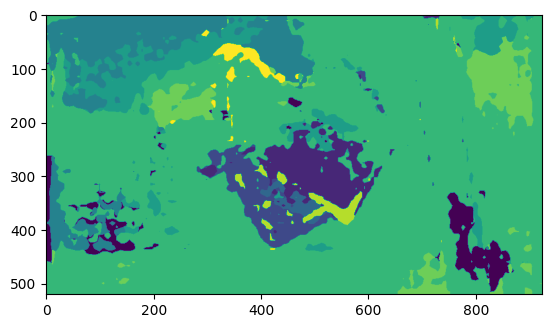

In [85]:
plt.imshow(instance_pred.reshape(520, 924))

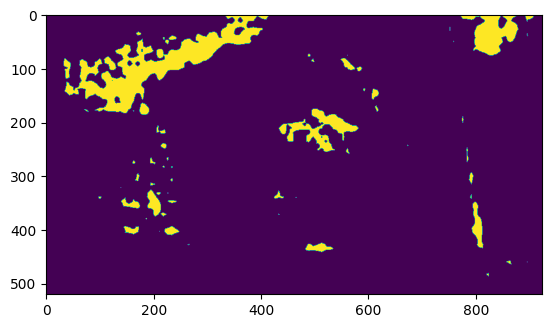

In [86]:
plt.imshow(instance_pred.reshape(520, 924) == 5)

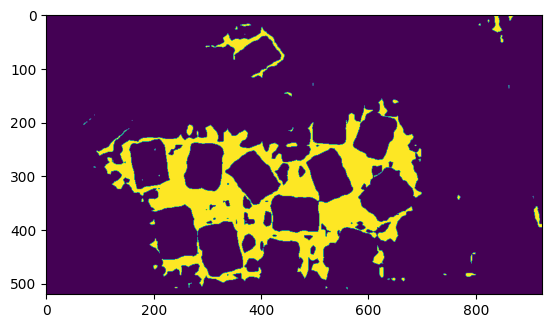

In [87]:
plt.imshow(instance_model.reshape(520, 924) == 5)

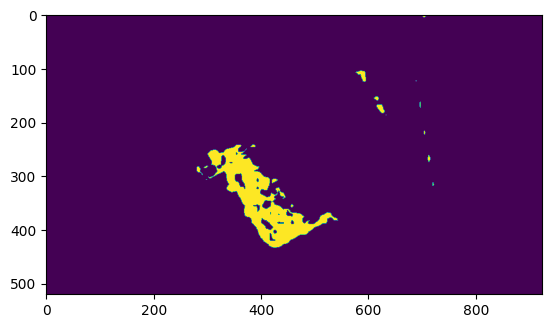

In [88]:
plt.imshow(instance_pred.reshape(520, 924) == 2)

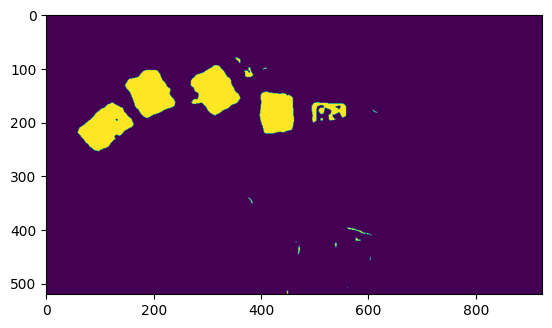

In [89]:
plt.imshow(instance_model.reshape(520, 924) == 2)